# <font color=blue>Overall View</font>
This notebook takes us through the whole training and hyper-parameter tuning process for the YOLOv3 model (implemented on Keras) and trained on the EgoHands dataset. At the end we choose our best model and hyper-parameters to train additionally and to test on the test dataset.

Note: this notebook should be run from the yolov3 directory inside the main directory HandDeterctor

# <font color=blue>Note about the data</font>
The EgoHands data obtained from http://vision.soic.indiana.edu/projects/egohands/

The raw .jpg images (1280 x 720) were downloaded into _LABELLED_SAMPLES_ folder and the ground truth annotations for the train and test images ('train_labels.csv' and 'test_labels.csv') were obtained from running the generate_egoHandsDataset.py function found in our main directory (HandDetector/) (note this function was obtained from the the original cloned git )

# <font color=blue>Note about Model</font>
The YOLOv3 model that we use here is cloned from the repository https://github.com/qqwweee/keras-yolo3 and is implemented in Keras

# <font color=blue>IOU = 0.45</font>
note the IOU used throughout is 0.45 (the report contained a typo and said IOU was 0.3 which is not the case)

# <font color=blue>Data Preparation</font>
We first generate train_labels.txt, validation_labels.txt and test_labels.txt in the required format using train_labels.csv and test_labels.csv <br>
Note the required format for the .txt files (as inidicated in https://github.com/qqwweee/keras-yolo3) is as follows:<br>
image_file_path box1 box2 ... boxN; Box format: x_min,y_min,x_max,y_max,class_id (no space).

We also generate the classes.txt file which only contains 1 class: 'hand'

In [2]:
import csv
csv_files = ['train_labels.csv','test_labels.csv']
txt_files = ['train_validation_labels.txt','test_labels.txt']
for i in range(2):
    csv_file = csv_files[i]
    txt_file = txt_files[i]    
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            csv_reader = csv.reader(my_input_file, delimiter=',')
            counter = -1
            curr_folder = ''
            curr_frame_name = ''
            for row in csv_reader:
                counter += 1
                if counter == 0 or row==[]:
                    continue
                word = row[0]
                cut = word.find('frame') 
                folder = row[0][:cut-1]
                frame_name = row[0][:]
                if folder == curr_folder and frame_name == curr_frame_name: #add on anot
                    my_output_file.write(str(row[4])+','+str(row[5])+','+str(row[6])+','+str(row[7])+','+'0 ')
                else :
                    if counter != 2:
                        my_output_file.write("\n")
                    my_output_file.write('_LABELLED_SAMPLES/' + folder + '/' + frame_name + ' ' +  str(row[4]) +',' 
                                         + str(row[5]) +',' + str(row[6]) + ',' + str(row[7]) + ',0 ')
                    curr_folder = folder
                    curr_frame_name = frame_name

In [3]:
#split train_val_labels.txt into 90% train_labels.txt and 10% validation_labels.txt
with open('train_validation_labels.txt') as f:
    for i, l in enumerate(f):
         pass
    line_count = i+1
    cutoff = int(line_count*0.9)
with open('train_validation_labels.txt',"r") as f:
    with open('train_labels.txt',"w") as train:
        with open('validation_labels.txt',"w") as val:
            for i, l in enumerate(f):
                if i <= cutoff:
                    train.write(l)
                else:
                    val.write(l)

In [4]:
txt_file = 'classes.txt'
with open(txt_file, "w") as my_output_file:
    my_output_file.write('hand') #only 1 class: hand

# <font color=blue>Hyper-parameter tuning</font>

In [44]:
import sys
sys.path.append('keras-yolo3')
from train_v2 import *
from yolo_video import *
from yolo import *
from yolo import YOLO, detect_video
from matplotlib import pyplot as plt
import numpy as np

Create YOLOv3 model with 9 anchors and 1 classes.
Load Yolo weights keras-yolo3/model_data/darknet53_weights.h5.
Freeze the first 249 layers of total 252 layers.
==========================================   Yolo Body   =========================================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 704, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 704, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 704, 1280, 32 128         conv2d_1[0][0]                   
______________________________________________

Start
step 0: [train loss: 51033.089844]
step 0: [val loss: 39925.487124] [val mAP: 0.000000]
step 98: [train loss: 28387.242188]
step 98: [val loss: 37179.984592] [val mAP: 0.000000]
step 196: [train loss: 17674.490234]
step 196: [val loss: 35352.794488] [val mAP: 0.000000]
step 294: [train loss: 11789.937500]
step 294: [val loss: 33992.971354] [val mAP: 0.000000]
step 392: [train loss: 8581.842773]
step 392: [val loss: 33006.358109] [val mAP: 0.000000]
step 490: [train loss: 8754.560547]
step 490: [val loss: 32202.984303] [val mAP: 0.000000]
step 588: [train loss: 5231.657715]
step 588: [val loss: 31570.174190] [val mAP: 0.000000]
step 686: [train loss: 4097.810547]
step 686: [val loss: 31012.533637] [val mAP: 0.000000]
step 784: [train loss: 4295.529785]
step 784: [val loss: 30549.706778] [val mAP: 0.000000]
step 882: [train loss: 2540.582520]
step 882: [val loss: 30152.969510] [val mAP: 0.000000]
step 980: [train loss: 2358.484131]
step 980: [val loss: 29817.515878] [val mAP: 0.000

[Text(0, 0.5, 'Validation mAP'), Text(0.5, 0, 'epoch')]

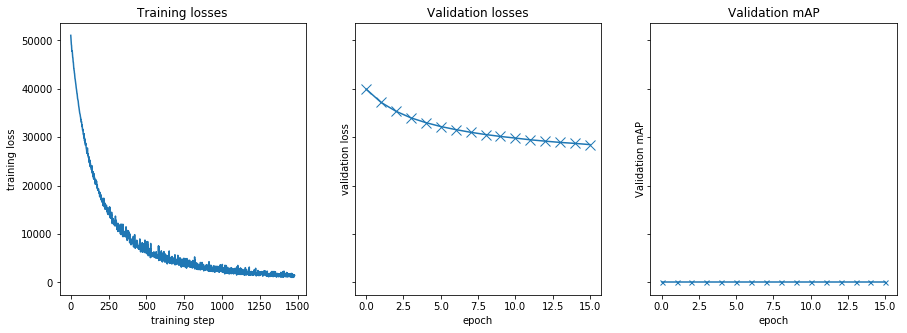

In [7]:
#training try 1
train_whole_body = False
model = Yolo('classes.txt','keras-yolo3/model_data/yolo_anchors.txt' , 'train_labels.txt', 'validation_labels.txt', 'test_labels.txt', 'keras-yolo3/model_data/darknet53_weights.h5', train_whole_body)
learning_rate = 1e-4
epochs = 3
train_losses_1, val_losses_1, mAPs_1, num_iter_1 = model.train(epochs, learning_rate)
#saving
np.save('train_losses_1', train_losses_1)
np.save('val_losses_1', val_losses_1)
np.save('mAPs_1', mAPs_1)
np.save('num_iter_1', num_iter_1)
#plotting
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
axs[0].plot(range(num_iter_1), train_losses_1)
axs[0].set_title('Training losses')
axs[0].set(xlabel='training step', ylabel='training loss')
axs[1].plot(range(len(val_losses_1)), val_losses_1 ,marker = 'x', linestyle = '-',markersize=10, )
axs[1].set_title('Validation losses')
axs[1].set(xlabel='epoch', ylabel='validation loss')
axs[2].plot(range(len(mAPs_1)), mAPs_1,  marker = 'x', markersize=5, linestyle = '-')
axs[2].set_title('Validation mAP')
axs[2].set(xlabel='epoch', ylabel='Validation mAP')

Create YOLOv3 model with 9 anchors and 1 classes.
Load Yolo weights keras-yolo3/model_data/darknet53_weights.h5.
Freeze the first 249 layers of total 252 layers.
==========================================   Yolo Body   =========================================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 704, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 704, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 704, 1280, 32 128         conv2d_1[0][0]                   
______________________________________________

Start
step 0: [train loss: 51033.089844]
step 0: [val loss: 39794.100260] [val mAP: 0.000000]
step 98: [train loss: 5738.481934]
step 98: [val loss: 31634.600152] [val mAP: 0.000000]
step 196: [train loss: 2234.394043]
step 196: [val loss: 29540.037724] [val mAP: 0.000000]
step 294: [train loss: 1182.565796]
step 294: [val loss: 28343.099609] [val mAP: 0.000000]
step 392: [train loss: 855.693420]
step 392: [val loss: 27581.793113] [val mAP: 0.000000]
step 490: [train loss: 1378.567627]
step 490: [val loss: 26997.274450] [val mAP: 0.000000]
step 588: [train loss: 523.420166]
step 588: [val loss: 26551.158782] [val mAP: 0.000000]
step 686: [train loss: 378.346619]
step 686: [val loss: 26149.816985] [val mAP: 0.000000]
step 784: [train loss: 505.746826]
step 784: [val loss: 25832.973958] [val mAP: 0.000000]
step 882: [train loss: 218.012848]
step 882: [val loss: 25564.557002] [val mAP: 0.000000]
step 980: [train loss: 222.448196]
step 980: [val loss: 25355.914026] [val mAP: 0.000000]
step

[Text(0, 0.5, 'Validation mAP'), Text(0.5, 0, 'epoch')]

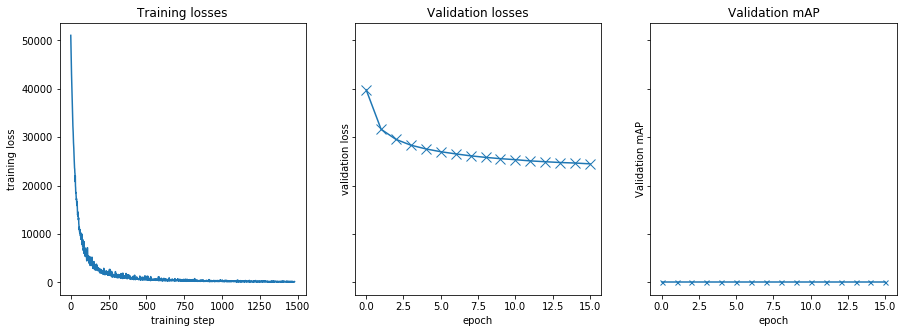

In [9]:
#training try 2
train_whole_body = False
model = Yolo('classes.txt','keras-yolo3/model_data/yolo_anchors.txt' , 'train_labels.txt', 'validation_labels.txt', 'test_labels.txt', 'keras-yolo3/model_data/darknet53_weights.h5', train_whole_body)
learning_rate = 5e-4
epochs = 3
train_losses_2, val_losses_2, mAPs_2, num_iter_2 = model.train(epochs, learning_rate)
#saving
np.save('train_losses_2', train_losses_2)
np.save('val_losses_2', val_losses_2)
np.save('mAPs_2', mAPs_2)
np.save('num_iter_2', num_iter_2)
#plotting
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
axs[0].plot(range(num_iter_2), train_losses_2)
axs[0].set_title('Training losses')
axs[0].set(xlabel='training step', ylabel='training loss')
axs[1].plot(range(len(val_losses_2)), val_losses_2 ,marker = 'x', linestyle = '-',markersize=10, )
axs[1].set_title('Validation losses')
axs[1].set(xlabel='epoch', ylabel='validation loss')
axs[2].plot(range(len(mAPs_2)), mAPs_2,  marker = 'x', markersize=5, linestyle = '-')
axs[2].set_title('Validation mAP')
axs[2].set(xlabel='epoch', ylabel='Validation mAP')

Instructions for updating:
Colocations handled automatically by placer.
Create YOLOv3 model with 9 anchors and 1 classes.
Load Yolo weights keras-yolo3/model_data/darknet53_weights.h5.
Freeze the first 249 layers of total 252 layers.
==========================================   Yolo Body   =========================================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 704, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 704, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 704, 1280, 32 128         conv2d_1

Start
step 0: [train loss: 41569.410156]
step 0: [val loss: 38893.276476] [val mAP: 0.000000]
step 98: [train loss: 1567.078247]
step 98: [val loss: 28819.001194] [val mAP: 0.000000]
step 196: [train loss: 591.862671]
step 196: [val loss: 27199.546260] [val mAP: 0.000000]
step 294: [train loss: 337.526123]
step 294: [val loss: 26207.163050] [val mAP: 0.000000]
step 392: [train loss: 263.702209]
step 392: [val loss: 25573.106409] [val mAP: 0.000000]
step 490: [train loss: 505.289764]
step 490: [val loss: 25082.977937] [val mAP: 0.000000]
step 588: [train loss: 184.659775]
step 588: [val loss: 24688.884621] [val mAP: 0.000000]
step 686: [train loss: 122.311783]
step 686: [val loss: 24362.586552] [val mAP: 0.002500]
step 784: [train loss: 181.308090]
step 784: [val loss: 24100.304507] [val mAP: 0.036297]
step 882: [train loss: 78.415047]
step 882: [val loss: 23891.443287] [val mAP: 0.050692]
step 980: [train loss: 83.144768]
step 980: [val loss: 23683.930339] [val mAP: 0.083269]
step 1078

[Text(0, 0.5, 'Validation mAP'), Text(0.5, 0, 'epoch')]

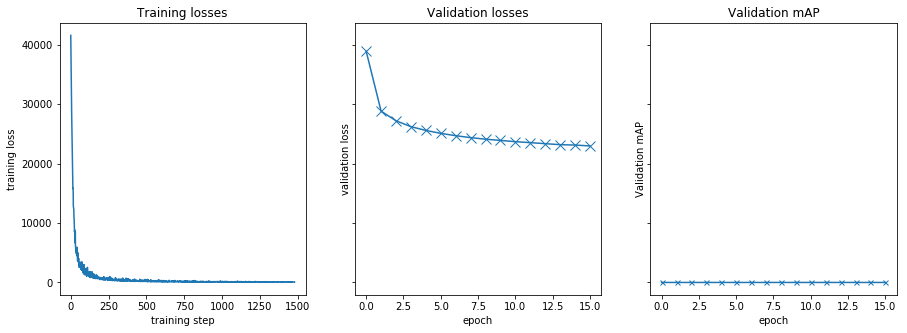

In [2]:
#training try 3
train_whole_body = False
model = Yolo('classes.txt','keras-yolo3/model_data/yolo_anchors.txt' , 'train_labels.txt', 'validation_labels.txt', 'test_labels.txt', 'keras-yolo3/model_data/darknet53_weights.h5', train_whole_body)
learning_rate = 1e-3
epochs = 3
train_losses_3, val_losses_3, mAPs_3, num_iter_3 = model.train(epochs, learning_rate)
#saving
np.save('train_losses_3', train_losses_3)
np.save('val_losses_3', val_losses_3)
np.save('mAPs_3', mAPs_3)
np.save('num_iter_3', num_iter_3)
#plotting
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
axs[0].plot(range(num_iter_3), train_losses_3)
axs[0].set_title('Training losses')
axs[0].set(xlabel='training step', ylabel='training loss')
axs[1].plot(range(len(val_losses_3)), val_losses_3 ,marker = 'x', linestyle = '-',markersize=10, )
axs[1].set_title('Validation losses')
axs[1].set(xlabel='epoch', ylabel='validation loss')
axs[2].plot(range(len(mAPs_3)), mAPs_3,  marker = 'x', markersize=5, linestyle = '-')
axs[2].set_title('Validation mAP')
axs[2].set(xlabel='epoch', ylabel='Validation mAP')

Instructions for updating:
Colocations handled automatically by placer.
Create YOLOv3 model with 9 anchors and 1 classes.
Load Yolo weights logs/models/darknet53_trained_3_0.001.h5.
Freeze the first 185 layers of total 252 layers.
==========================================   Yolo Body   =========================================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 704, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 704, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 704, 1280, 32 128         conv2d_1[0]

Start
step 0: [train loss: 47.144577]
step 0: [val loss: 515.017292] [val mAP: 0.000106]
step 98: [train loss: 27.560419]
step 98: [val loss: 33.017482] [val mAP: 0.171756]
step 196: [train loss: 20.441483]
step 196: [val loss: 29.690435] [val mAP: 2.715066]
step 294: [train loss: 21.879202]
step 294: [val loss: 27.906516] [val mAP: 9.445909]
step 392: [train loss: 21.214457]
step 392: [val loss: 28.963114] [val mAP: 8.709918]
step 490: [train loss: 27.612972]
step 490: [val loss: 26.028670] [val mAP: 16.796404]
step 588: [train loss: 25.793787]
step 588: [val loss: 26.188603] [val mAP: 18.824368]
step 686: [train loss: 18.300657]
step 686: [val loss: 23.726407] [val mAP: 27.897956]
step 784: [train loss: 20.131977]
step 784: [val loss: 22.723286] [val mAP: 33.876370]
step 882: [train loss: 20.980879]
step 882: [val loss: 24.608214] [val mAP: 22.722467]
step 980: [train loss: 20.602110]
step 980: [val loss: 23.931875] [val mAP: 29.269692]
step 1078: [train loss: 19.918314]
step 1078: [

step 9016: [val loss: 17.177834] [val mAP: 41.805072]
step 9114: [train loss: 15.721828]
step 9114: [val loss: 17.000533] [val mAP: 44.373220]
step 9212: [train loss: 15.181655]
step 9212: [val loss: 18.133678] [val mAP: 41.270587]
step 9310: [train loss: 14.659830]
step 9310: [val loss: 17.725207] [val mAP: 41.229514]
step 9408: [train loss: 19.273092]
step 9408: [val loss: 16.963197] [val mAP: 41.315963]
step 9506: [train loss: 17.671322]
step 9506: [val loss: 17.615233] [val mAP: 42.295621]
step 9604: [train loss: 16.024023]
step 9604: [val loss: 17.619715] [val mAP: 43.889993]
step 9702: [train loss: 16.040289]
step 9702: [val loss: 17.144969] [val mAP: 41.705787]
step 9800: [train loss: 10.658788]
step 9800: [val loss: 17.258712] [val mAP: 43.336708]


ValueError: x and y must have same first dimension, but have shapes (20,) and (101,)

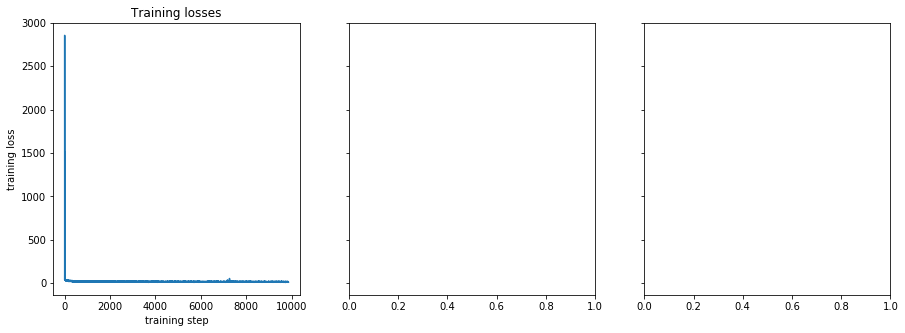

In [3]:
#now we take our best try and unfreeze the whole body of Yolov3 and train for an additional 20 epochs
#(previously in trys 1,2 and 3 only the top 3 layers were unfrozen)
train_whole_body = True #notice 
best_model_path = 'logs/models/darknet53_trained_3_0.001.h5'
best_learning_rate = 1e-3
model = Yolo('classes.txt','keras-yolo3/model_data/yolo_anchors.txt' , 'train_labels.txt', 'validation_labels.txt', 'test_labels.txt', best_model_path, train_whole_body)
learning_rate = best_learning_rate
epochs = 20
train_losses, val_losses, mAPs, num_iter = model.train(epochs, learning_rate)
#saving
np.save('train_losses', train_losses)
np.save('val_losses', val_losses)
np.save('mAPs', mAPs)
np.save('num_iter', num_iter)

[Text(0, 0.5, 'validation mAP'), Text(0.5, 0, 'epoch')]

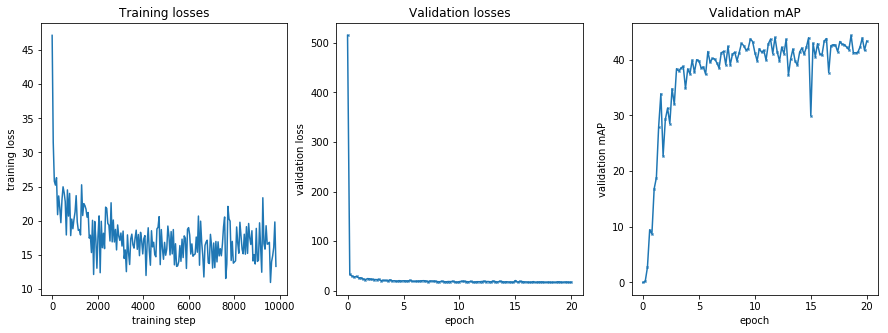

In [30]:
#plotting training results
train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')
mAPs = np.load('mAPs.npy')
num_iter = np.load('num_iter.npy')
f, axs = plt.subplots(1, 3, sharey=False, figsize=(15,5))
axs[0].plot(range(0,num_iter,48 ), train_losses[range(0,num_iter,48 )])
axs[0].set_title('Training losses')
axs[0].set(xlabel='training step', ylabel='training loss')
axs[1].plot(np.asarray(range(len(val_losses)))/5, val_losses ,marker = 'x', linestyle = '-',markersize=2, )
axs[1].set_title('Validation losses')
axs[1].set(xlabel='epoch', ylabel='validation loss')
axs[2].plot(np.asarray(range(len(mAPs)))/5, mAPs ,marker = 'x', linestyle = '-',markersize=2, )
axs[2].set_title('Validation mAP')
axs[2].set(xlabel='epoch', ylabel='validation mAP')

In [33]:
#calculate test mAP for our best model
%cp logs/models/darknet53_trained_20_0.001.h5 logs/models/best_model.h5
best_model = Yolo('classes.txt','keras-yolo3/model_data/yolo_anchors.txt' , 'train_labels.txt', 'validation_labels.txt', 'test_labels.txt', 'logs/models/best_model.h5', False)
mAP = best_model.eval(1, best_model.test_data, best_model.tmp_gt_files_path, 'mAP')
print("The mAP of our best model on the test set is: %f" % mAP)

Create YOLOv3 model with 9 anchors and 1 classes.
Load Yolo weights logs/models/best_model.h5.
Freeze the first 249 layers of total 252 layers.
==========================================   Yolo Body   =========================================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 704, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 704, 1280, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 704, 1280, 32 128         conv2d_1[0][0]                   
________________________________________________________________

The mAP of our best model on the test set is: 38.572933


logs/models/best_model.h5 model, anchors, and classes loaded.
(704, 1280, 3)
Found 20 boxes for img
10.712294858007226


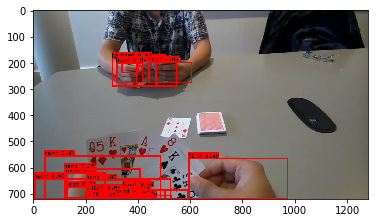

In [47]:
#visualize some predictions of our best model
from matplotlib.figure import Figure
index =  82#choose an image index from 0 to 399 to test prediction on
f=open('test_labels.txt')
lines=f.readlines()
image = lines[index].split(" ",1)[0]

best_model = YOLO()
img = detect_img(best_model,image)
#best_model.close_session()
Figure(figsize = (30,30))
imshow(np.asarray(img))